In [94]:
# Using Python 3.9.6 64-bit
# Install libraries

# pip3 install os
# pip3 install pandas 
# pip3 install glob

In [95]:
import os
import pandas as pd
import glob
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.corpus import stopwords
import string 
import matplotlib.pyplot as plt
import re
# from bs4 import BeautifulSoup
%matplotlib inline

In order to maintain the ham:spam ratio (which differs in each folder we have been provided), we have collated all the "ham" text files into one large "ham" array, and all the spam text files into one large "spam array". 

To achieve this we used the libraries *os* and *glob*: the former sets/changes the working directory, while the latter searches for a specific file pattern. Since our ham/spam folders were nested, glob was really useful......

In [96]:
# Set working directory: 
path = "C:/Users/64277/OneDrive - AUT University/Data Mining - COMP723/Data Mining Assignment"

# Change the working directory 
os.chdir(path)

ham_spam_files = glob.glob(path + '/enron*/*am/*am.txt')

In [97]:
# debug - iterating through lists in python *** CAN DELETE LATER ***

# firstTen = ham_spam_files[0:10]

# # print(firstTen)

# n = 0
# for file in ham_spam_files: 

#     if "enron1" in file: 
#         n+=1
#     if "spam" in file: 
#         print("success")

# print("There are", n, "text files within enron1")

In [98]:
'''Iterate through all the files'''
# print(enron_folder)

# loop through list of files and store the output into a dataframe using DataFrame.loc
i = 0

column_names = ["category", "message", "enron folder"]
df = pd.DataFrame(columns = column_names)
for f in ham_spam_files:
    # see if enron1, 2, 3, 4, 5: 
    if "spam" in f: 
        df.loc[i, ['category']] = "spam"
    if "ham" in f: 
        df.loc[i, ['category']] = "ham"
    # get the folder 
    for x in range(1,6): 

        if ("enron" + str(x)) in f: 
            df.loc[i, ['enron folder']]= "enron" + str(x)
    # open the file path and read in text
    with open(f, 'r', encoding = 'ascii', errors='ignore') as file:
        df.loc[i, ['message']] = file.read()

    # append temp_df to the end of the main dataframe
    # main_df.append(temp_df)
    i += 1


#Print result
print(f'Successfully created  Temp dataframe for Ham:Spam with shape {df.shape}')
  

Successfully created  Temp dataframe for Ham:Spam with shape (27716, 3)


In [99]:
''' Explore the data'''
# print row one of the data frame to check our data
print(df.iloc[0])

# verify shape one more time
print(f'Shape of our dataframe is {df.shape}')

# how many words are in the data?

print(df['message'].apply(lambda x: len(x.split(' '))).sum())
# there are 7 million words in our dataset


category                                            ham
message         Subject: christmas tree farm pictures\n
enron folder                                     enron1
Name: 0, dtype: object
Shape of our dataframe is (27716, 3)
8109764


In [100]:
'''Clean the data'''

# check for duplicates and remove them 
df.drop_duplicates(inplace = True) 

# show the new shape
df.shape

# drops 661 rows from our dataset!

(27055, 3)

In [101]:
'''Clean the data 2.0 '''
# show the number of missing data (e.g., "Nan","NAN" or "na") for each column

df.isnull().sum()

# no missing data!

category        0
message         0
enron folder    0
dtype: int64

In [102]:
#Convert the Category field from text to an int
#The models will out a number ranging from 0-1 corresponding to the spam or ham
# def convert_category(text):
#     if text == "spam":
#         return 0
#     elif text == "ham":
#         return 1

# convert_category(df['category'])

df['label'] = df['category'].apply(lambda x:1 if x=='spam' else 0)

df.sample(5)

,category,message,enron folder,label
15338,spam,Subject: l ' m reai | | y surprlsed . . .\ncii...,enron3,1
12558,ham,Subject: article : ipe stays calm over new yor...,enron3,0
22019,spam,Subject: doctors use this too 8 cnom\nci - ial...,enron4,1
10479,spam,Subject: are you ready to get it ?\nhello !\nv...,enron2,1
7782,ham,"Subject: projects list\nstinson ,\njust want t...",enron2,0


In [103]:
# Define a baseline model
# This is the model we will be using to compare it to the more advanced models, such as neural networks, naive bayes and random forest. 

from sklearn.model_selection import train_test_split

emails = df['message'].values
y = df['label'].values


email_train, email_test, y_train, y_test = train_test_split(
  emails, y, test_size=0.3, random_state=1000, stratify = y)


In [104]:
# Vectorise the emails with a Bag of Words (BoW) approach using the CountVectorizer from SkLearn
from sklearn.feature_extraction.text import CountVectorizer

BoWvectorizer = CountVectorizer()

# center the training set - standard score

BoW_result= BoWvectorizer.fit(email_train)
print(BoW_result)

# transform the rest of the data
X_train = BoW_result.transform(email_train)
X_test = BoW_result.transform(email_test)

X_train

CountVectorizer()


<18938x114646 sparse matrix of type '<class 'numpy.int64'>'
	with 2214517 stored elements in Compressed Sparse Row format>

The resulting feature vectors have 18,938 samples which is also the number of training samples after the train_test split.  
Each sample has 114,646 dimensions which is the size of the words in our sample's largest email (i.e., this is the size of our vocabulary)

The count vectoriser also gives us a sparse matrix. This is a type of matrices that is less intensive on the processing memory as it only counts non-zero elements in matrices where there are few non-zero elements. 

Python's CountVectoriser() function tokenises each word in the email message, and it removes special punctuation and other special characters. 
#TODO: it is possible to use a custom tokeniser with CountVectoriser using the nltk library

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

classifier = LogisticRegression(class_weight = "balanced", max_iter = 100000000)
classifier.fit(X_train, y_train)

## calculate prediction

y_pred = classifier.predict(X_test)
target_names = ['Spam', 'Ham']

## get the accuracy and f1 scores

# f1 score
f1score = f1_score(y_test, y_pred)
print(f"F1 score: {f1score * 100}% ")

# accuracy
print('Accuracy: %s' % accuracy_score(y_pred, y_test))

# classification report
report = classification_report(y_test, y_pred,target_names=target_names)
print(report)

F1 score: 98.79230258792302% 
Accuracy: 0.9887889614389552
              precision    recall  f1-score   support

        Spam       0.99      0.98      0.99      4371
         Ham       0.98      0.99      0.99      3746

    accuracy                           0.99      8117
   macro avg       0.99      0.99      0.99      8117
weighted avg       0.99      0.99      0.99      8117



In [106]:
# classifier.show_most_informative_features(20)-- works for naive bayes
import math
from sklearn.feature_selection import RFE

# feature_importance = pd.DataFrame(target_names, columns = ["feature"])
# feature_importance["importance"] = pow(math.e, w)
# feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)

# rfe = RFE(classifier, 3)
# fit = rfe.fit(email_train, email_test)
# print("Num Features: %d" % fit.n_features_)
# print("Selected Features: %s" % fit.support_)
# print("Feature Ranking: %s" % fit.ranking_)
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4304,   67],
       [  24, 3722]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

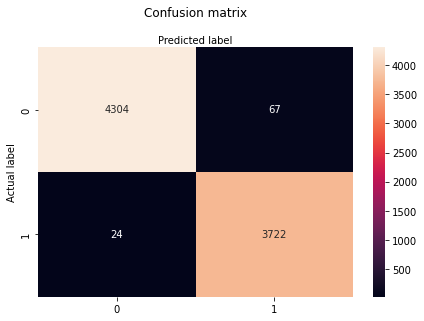

In [107]:
## Visual confusion matrix: 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="rocket" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Deep Neural Networks learning model

we want to use the sigmoid function for the output layer since we are dealing with a binary classification problem
if it were a multi-label classification problem then we would want to use the softmax function for the output layer

weights most important part of a neural network - start with random values and then uses the backpropogation method. 

Dependencies: 
- **pip install keras**
- **pip install tensorflow**

Note: **pip install tensorflow** might not work so try **pip install tensorflow --user** in Windows 


The default settings include: 

    - "image_data_format": "channels_last",
    - "epsilon": 1e-07,
    - "floatx": "float32",
    - "backend": "tensorflow

(These can be found in the json file, enter: "%USERPROFILE%/.keras/keras.json" into command prompt on windows, 
or $HOME/.keras/keras.json on mac. 



In [108]:
# # check tensorflow version: 
# import tensorflow as tf
# tf.__version__

# # using version 2.6.1
# from keras.models import Sequential
# from keras import layers

# input_dim = X_train.shape[1]  # Number of features
# model = Sequential()
# model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))


In [109]:
# # Summary of Keras NN model
# model.compile(loss='binary_crossentropy', 
#              optimizer='adam', 
#             metrics=['accuracy'])
# model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                1146470   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,146,481
Trainable params: 1,146,481
Non-trainable params: 0
_________________________________________________________________


In [114]:
# Fit the NN Model to the data: 
# X_train[:15380]
# print(X_train) #  (18937, 113176)
# # print(y_train) # length 15380, 27,715)
# history = model.fit(X_train[:15380], y_train,
#                     epochs=100,
#                     verbose=False,
#                     validation_data=(X_test[:15380], y_test),
#                     batch_size=10)

# X_train.getnnz()

2214517

In [128]:
# Applying Neural Network model logistic on the data #
from sklearn.neural_network import MLPClassifier

clf1 = MLPClassifier(activation='logistic', solver='lbfgs', learning_rate_init=0.1, alpha=1e-5,
                        hidden_layer_sizes=(5, 2), random_state=1,max_iter=2000)
#clf.fit(predicted_train, np.ravel(target_train, order='C'))
clf1 = clf1.fit(X_train, y_train)
predictions = clf1.predict(X_test)

# Get performance of algorithm
f1score3 = f1_score(y_test, y_pred)
print(f"F1 score with Neural Network MLP Classifier: {f1score3 * 100}% ")
print("**")

# Get classification stats
print("Accuracy with Neural Network MLP Classifier: ", metrics.accuracy_score(y_test, y_pred))
print("**")

print("Classification Report: ", classification_report(y_test,y_pred))
print("*")
#print("Neural Network Classifier Accuracy score: ", accuracy_score(y_test, y_pred))

# Get confusion matrix
print("Neural Network Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("\nEnd")

F1 score with Neural Network MLP Classifier: 96.0172228202368% 
**
Accuracy with Neural Network MLP Classifier:  0.9588008565310493
**
Classification Report:                precision    recall  f1-score   support

           0       0.99      0.93      0.96      5827
           1       0.93      0.99      0.96      5848

    accuracy                           0.96     11675
   macro avg       0.96      0.96      0.96     11675
weighted avg       0.96      0.96      0.96     11675

*
Neural Network Confusion Matrix: 
 [[5396  431]
 [  50 5798]]

End


# Naive Bayes 

- multinomial naive bayes

In [116]:
# Model Generation using Multinomial Naive Bayes #
from sklearn.naive_bayes import MultinomialNB

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
clf = MultinomialNB().fit(X_train, y_train)
y_pred= clf.predict(X_test)

# Get performance of algorithm
f1score2 = f1_score(y_test, y_pred)
print(f"F1 score with MultinomialNB: {f1score2 * 100}% ")
print("**")

# Get classification stats
print("Accuracy with MultinomialNB: ", metrics.accuracy_score(y_test, y_pred))
print("**")

print("Classification Report: ", classification_report(y_test,y_pred))
print("**")
#print("MultinomialNB Classifier Accuracy score: ", accuracy_score(y_test, y_pred))

# Get confusion matrix
print("MultinomialNB Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("\nEnd")

F1 score with MultinomialNB: 98.9081225033289% 
**
Accuracy with MultinomialNB:  0.9898977454724652
**
Classification Report:                precision    recall  f1-score   support

           0       0.99      0.99      0.99      4371
           1       0.99      0.99      0.99      3746

    accuracy                           0.99      8117
   macro avg       0.99      0.99      0.99      8117
weighted avg       0.99      0.99      0.99      8117

**
MultinomialNB Confusion Matrix: 
 [[4321   50]
 [  32 3714]]

End


In [118]:
# # Import spaCy and load the language library
# import spacy
# #you will need this line below to download the package
# #!python -m spacy download en_core_web_sm
# nlp = spacy.load('en_core_web_sm')

# # Convert dataframe to string
# #df['message']= df['message'].apply(str)

# # Create a Doc object of df
# doc = nlp(df[0, 'message'].values)
# token_list = []
# # collect each token separately with their POS Tag, dependencies and lemma
# for token in doc:
#     output = [token.text, token.pos_, token.dep_,token.lemma_]
#     token_list.append(output)
# # create DataFrame using data 
# df_tokenised = pd.DataFrame(token_list, columns =['Word', 'POS Tag', 'Dependencies', 'Lemmatized Word']) 

# Part II. Using a second base line model --- lets test the classifiers using this data!

In [121]:
# Second baseline model using enron 1, 3, 5  as training data and enron 2, 4 as test data

x_train_df = df.loc[(df['enron folder'] == "enron1") |(df['enron folder'] == "enron3" ) | (df['enron folder'] == "enron5")]
x_train2 = x_train_df['message'].values # training email messages
x_test_df = df[(df['enron folder'] == "enron2") |(df['enron folder'] == "enron4" )] 
x_test2 = x_test_df['message'] # testing email messages
y_train_df = df[(df['enron folder'] == "enron1") |(df['enron folder'] == "enron3" ) | (df['enron folder'] == "enron5")] 
y_train2 = y_train_df['label']# training labels
y_test_df = df[(df['enron folder'] == "enron2") |(df['enron folder'] == "enron4" )] 
y_test2 = y_test_df['label']# testing labels

# debug to make sure this has worked
# print(y_test[:10])
# print(y_test[-10:])
# print(x_train[:10])
# print(x_train[-10:])
#  # etc

In [125]:
# Vectorise the emails with a Bag of Words (BoW) approach using the CountVectorizer from SkLearn
# from sklearn.feature_extraction.text import CountVectorizer
# ^^^^ this should already be imported from above

BoWvectorizer = CountVectorizer()

# center the training set - standard score

BoW_result2 = BoWvectorizer.fit(x_train2)
print(BoW_result2)

# transform the rest of the data
x_train2 = BoW_result2.transform(x_train2)
x_test2 = BoW_result2.transform(x_test2)

CountVectorizer()


# II. Logistic Regression 

In [126]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score

classifier = LogisticRegression(class_weight = "balanced", max_iter = 100000000)
classifier.fit(x_train2, y_train2)

## calculate prediction
y_pred2 = classifier.predict(x_test2)
target_names = ['Spam', 'Ham']

## get the accuracy and f1 scores

# f1 score
f1score = f1_score(y_test2, y_pred2)
print(f"F1 score: {f1score * 100}% ")

# accuracy
print('Accuracy: %s' % accuracy_score(y_pred2, y_test2))

# classification report
report = classification_report(y_test2, y_pred2,target_names=target_names)

F1 score: 96.0172228202368% 
Accuracy: 0.9588008565310493


# II. Naive Bayes

In [127]:
# Model Generation using Multinomial Naive Bayes #
# from sklearn.naive_bayes import MultinomialNB

#Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
clf = MultinomialNB().fit(x_train2, y_train2)
y_pred2_nb= clf.predict(x_test2)

# Get performance of algorithm
f1score2_nb = f1_score(y_test2, y_pred2_nb)
print(f"F1 score with MultinomialNB: {f1score2_nb * 100}% ")
print("**")

# Get classification stats
print("Accuracy with MultinomialNB: ", metrics.accuracy_score(y_test2, y_pred2_nb))
print("**")

print("Classification Report: ", classification_report(y_test2,y_pred2_nb))
print("**")
#print("MultinomialNB Classifier Accuracy score: ", accuracy_score(y_test, y_pred))

# Get confusion matrix
print("MultinomialNB Confusion Matrix: \n",confusion_matrix(y_test2,y_pred2_nb))
print("\nEnd")

F1 score with MultinomialNB: 96.9220475075276% 
**
Accuracy with MultinomialNB:  0.9684796573875804
**
Classification Report:                precision    recall  f1-score   support

           0       0.99      0.95      0.97      5827
           1       0.95      0.99      0.97      5848

    accuracy                           0.97     11675
   macro avg       0.97      0.97      0.97     11675
weighted avg       0.97      0.97      0.97     11675

**
MultinomialNB Confusion Matrix: 
 [[5513  314]
 [  54 5794]]

End


# II. Neural Networks - Multi Layer Pereceptron (MLP) Layer

In [129]:
# Applying Neural Network model logistic on the data #
# from sklearn.neural_network import MLPClassifier

clf1 = MLPClassifier(activation='logistic', solver='lbfgs', learning_rate_init=0.1, alpha=1e-5,
                        hidden_layer_sizes=(5, 2), random_state=1,max_iter=2000)
#clf.fit(predicted_train, np.ravel(target_train, order='C'))
clf1 = clf1.fit(x_train2, y_train2)
y_pred2_nn = clf1.predict(x_test2)

# Get performance of algorithm
f1score2_nn = f1_score(y_test2, y_pred2_nn)
print(f"F1 score with Neural Network MLP Classifier: {f1score2_nn * 100}% ")
print("**")

# Get classification stats
print("Accuracy with Neural Network MLP Classifier: ", metrics.accuracy_score(y_test2, y_pred2_nn))
print("**")

print("Classification Report: ", classification_report(y_test2,y_pred2_nn))
print("**")
#print("Neural Network Classifier Accuracy score: ", accuracy_score(y_test, y_pred))

# Get confusion matrix
print("Neural Network Confusion Matrix: \n",confusion_matrix(y_test2,y_pred2_nn))
print("\nEnd")

F1 score with Neural Network MLP Classifier: 97.610979329041% 
**
Accuracy with Neural Network MLP Classifier:  0.9758458244111349
**
Classification Report:                precision    recall  f1-score   support

           0       0.98      0.97      0.98      5827
           1       0.97      0.99      0.98      5848

    accuracy                           0.98     11675
   macro avg       0.98      0.98      0.98     11675
weighted avg       0.98      0.98      0.98     11675

**
Neural Network Confusion Matrix: 
 [[5632  195]
 [  87 5761]]

End


# II. TF-IFD vectoriser trial....

In the previous chunks we have been using the CountVectorizer() function (Bag of Words), but since our accuracy and recall has dropped in the [enron1, enron5, enron3]:[enron2, enron4] data - compared to the 70:30 split data, it might be worthwhile to try another type of vectoriser to see if it improves. 

## Explanation of TF-IDF

Using TF-IDF instead of BOW, TF-IDF also takes into account the frequency instead of just the occurence.
This is calculated as:

* Term frequency = (Number of Occurrences of a word)/(Total words in the document)**

* IDF(word) = Log((Total number of documents)/(Number of documents containing the word))** 

* TF-IDF is the product of the two.**

In [136]:
from sklearn.feature_extraction.text import TfidfTransformer
# tfidfconverter = TfidfTransformer()
# tfidf_result = tfidfconverter(x_train2)

tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
tfidf_wm = tfidfvectorizer.fit_transform(x_train2)

# get feature names: 
tfidf_tokens = tfidfvectorizer.get_feature_names()
# print(tfidf_result.idf_)

# x_train2_tfidf = tfidf_result.transform(x_train2)
# x_test2_tfidf = tfidf_result.transform(x_test2)

################

# BoWvectorizer = CountVectorizer()

# # center the training set - standard score

# BoW_result2 = BoWvectorizer.fit(x_train2)
# print(BoW_result2)

# # transform the rest of the data
# x_train2 = BoW_result2.transform(x_train2)
# x_test2 = BoW_result2.transform(x_test2)

TypeError: 'TfidfTransformer' object is not callable

References: 

